In [2]:
import pandas as pd
import numpy as np
import statsmodels as sm
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima, ADFTest
import math
from matplotlib.legend_handler import HandlerTuple
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

In [ ]:
df = pd.read_excel("/Users/ashademeij/Downloads/Life Insurance I/Life-Insurance/LifeTables-NL.xlsx", skiprows=2)
df = df.replace({'110+': 110})  # Convert '110+' to numeric
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')
df['qx'] = pd.to_numeric(df['qx'], errors='coerce')

In [ ]:

def lee_carter(data, start_year, end_year):

    d = data[(data['Year'] >= start_year) & (data['Year'] <= end_year)].copy()
    d['log_qx'] = np.log(d['qx'])

    ages = np.sort(d['Age'].unique())
    years = np.sort(d['Year'].unique())

    logQ = d.pivot(index='Age', columns='Year', values='log_qx')
    logQ = logQ.reindex(index=ages, columns=years)

    alpha_x = logQ.mean(axis=1)  
    U = logQ.sub(alpha_x, axis=0).fillna(0).values  

    # SVD
    L, D, R_t = np.linalg.svd(U, full_matrices=False)
    d1 = D[0]        
    L1 = L[:, 0]     
    R1 = R_t[0, :]   

    # 5) Rank-1 approximation => U ~ d1 * L1 * R1
    raw_beta_x = L1
    raw_kappa_t = d1 * R1

    # Normalizations: sum_x(beta_x) = 1  and  sum_t(kappa_t) = 0
    sum_beta = raw_beta_x.sum()
    beta_x = raw_beta_x / sum_beta
    kappa_t = raw_kappa_t * sum_beta

    kappa_mean = np.mean(kappa_t)
    kappa_t = kappa_t - kappa_mean
    alpha_x = alpha_x + beta_x * kappa_mean  

    # # residuals epsilon_{x,t} = logQ - (alpha_x + beta_x*kappa_t)
    # alpha_array = alpha_x.values.reshape(-1, 1) 
    # beta_array  = beta_x.reshape(-1, 1)        
    # kappa_array = np.array(kappa_t)            
    # fitted_matrix = alpha_array + beta_array @ kappa_array[np.newaxis, :]
    # epsilon_matrix = logQ.values - fitted_matrix
    # epsilon_df = pd.DataFrame(
    #     data=epsilon_matrix,
    #     index=ages,
    #     columns=years
    # )

    return {
        'alpha_x': alpha_x,            
        'beta_x': beta_x,             
        'kappa_t': kappa_t,            
        'ages': ages,                  
        'years': years,
        'logQ': logQ,                  # original log(q_{x,t})
        # 'epsilon': epsilon_df          # residuals
    }


In [7]:
def plot_lee_carter(lc_res, period_label):

    ages = lc_res['ages']
    years = lc_res['years']
    alpha = lc_res['alpha_x']
    beta = lc_res['beta_x']
    kappa = lc_res['kappa_t']

    # Create a single figure with 3 subplots side by side
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Plot Alpha(x)
    axes[0].plot(ages, alpha, color="blue")
    axes[0].set_title(f"Alpha(x), {period_label}")
    axes[0].set_xlabel("Age")
    axes[0].set_ylabel("Alpha")
    axes[0].grid(True)

    # Plot Beta(x)
    axes[1].plot(ages, beta, color="red")
    axes[1].set_title(f"Beta(x), {period_label}")
    axes[1].set_xlabel("Age")
    axes[1].set_ylabel("Beta")
    axes[1].grid(True)

    # Plot Kappa(t)
    axes[2].plot(years, kappa, color="darkgreen")
    axes[2].set_title(f"Kappa(t), {period_label}")
    axes[2].set_xlabel("Year")
    axes[2].set_ylabel("Kappa")
    axes[2].grid(True)

    # Adjust layout for clarity
    plt.tight_layout()
    plt.show()


Plotting results for period 1950–2016


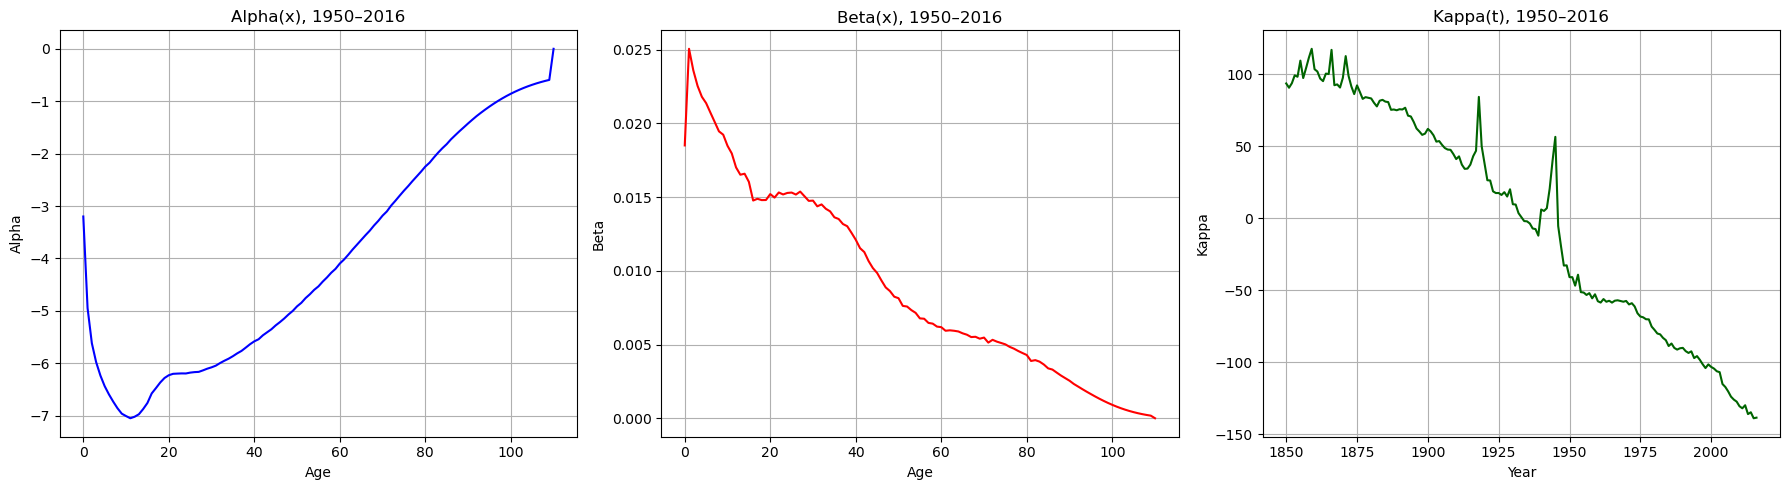

Plotting results for period 1970–2016


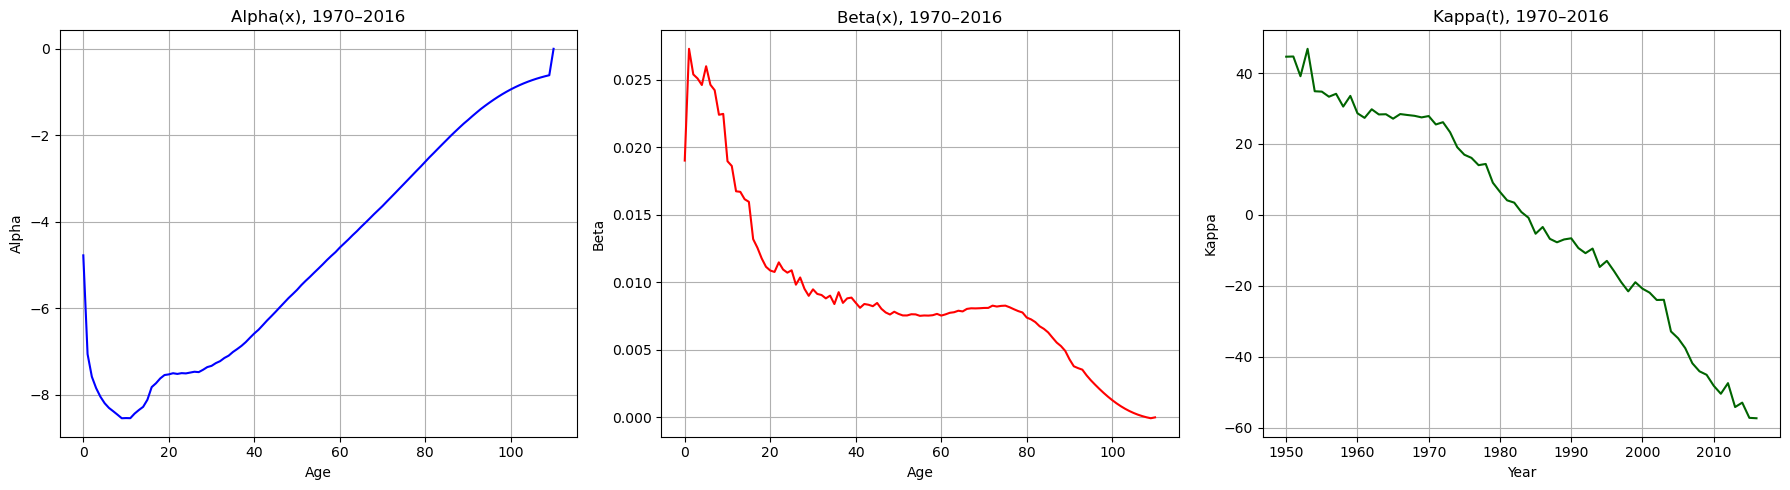

Plotting results for period 1980–2016


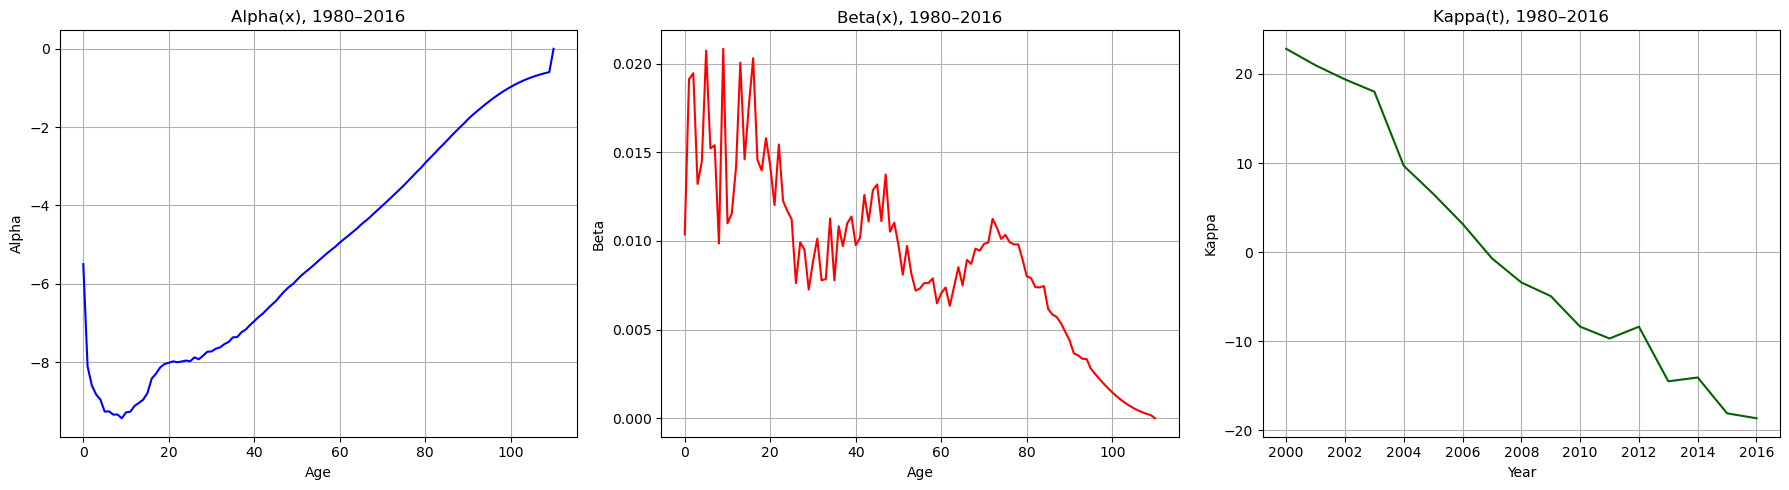

In [ ]:
periods = {
    "1950–2016": (1850, 2016),
    "1970–2016": (1950, 2016),
    "1980–2016": (2000, 2016)
}

results = {label: lee_carter(df, start, end) for label, (start, end) in periods.items()}

for label, res in results.items():
    print(f"Plotting results for period {label}")
    plot_lee_carter(res, label)

In [ ]:
# def forecast_kappa_arima(lee_carter_fit, forecast_start=2017, forecast_end=2100):

#     # Extract kappa_t and years
#     kappa_t = lee_carter_fit['kappa_t']
#     years = lee_carter_fit['years']
    
#     # Put kappa_t into a pandas Series for convenience
#     kappa_series = pd.Series(kappa_t, index=years).sort_index()
    
#     # Fit an ARIMA model with automatic order selection
#     model = pm.auto_arima(
#         kappa_series,
#         start_p=0, start_q=0,       # initial p, q
#         max_p=5, max_q=5,           # maximum p, q to consider
#         seasonal=False,             # Lee–Carter typically uses non-seasonal ARIMA
#         trace=False,                # set True if you want console output
#         error_action='ignore',
#         suppress_warnings=True
#     )
    
#     # Print the discovered optimal ARIMA order and the full summary
#     print("Optimal ARIMA model order (p, d, q):", model.order)
#     print("\nModel summary:")
#     print(model.summary())

#     # Generate future years and forecast
#     future_years = np.arange(forecast_start, forecast_end + 1)
#     n_periods = len(future_years)
    
#     forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)
    
#     # Build a DataFrame of forecasts
#     forecast_df = pd.DataFrame({
#         'Year': future_years,
#         'kappa_forecast': forecast,
#         'lower_ci': conf_int[:, 0],
#         'upper_ci': conf_int[:, 1]
#     })
    
#     return forecast_df


In [ ]:
#  ARIMA model with the order (0,1,0)

def forecast_kappa_arima(lee_carter_fit, forecast_start=2017, forecast_end=2100):

    kappa_t = lee_carter_fit['kappa_t']
    years = lee_carter_fit['years']
    kappa_series = pd.Series(kappa_t, index=years).sort_index()
    
    # ARIMA(0,1,0) model 
    model = pm.auto_arima(
        kappa_series,
        order=(0, 1, 0),           
        seasonal=False,            
        trace=True,                
        error_action='ignore',
        suppress_warnings=True
    )
    
    print("Fixed ARIMA model order (0,1,0)")
    print(model.summary())

    future_years = np.arange(forecast_start, forecast_end + 1)
    n_periods = len(future_years)
    
    forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)
    
    forecast_df = pd.DataFrame({
        'Year': future_years,
        'kappa_forecast': forecast,
        'lower_ci': conf_int[:, 0],
        'upper_ci': conf_int[:, 1]
    })
    
    return forecast_df

In [ ]:
start_year = 1950
end_year = 2016

# Fit Lee–Carter
lc_fit = lee_carter(df, start_year, end_year)
# Forecast kappa 
kappa_forecast_df = forecast_kappa_arima(lc_fit, forecast_start=2017, forecast_end=2100)

print(kappa_forecast_df.head())

Optimal ARIMA model order (p, d, q): (1, 1, 0)

Model summary:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   67
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -154.140
Date:                Wed, 26 Feb 2025   AIC                            314.280
Time:                        16:51:00   BIC                            320.849
Sample:                             0   HQIC                           316.876
                                 - 67                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.3459      0.339     -6.915      0.000      -3.011      -1.681
ar.L1         -0.5027      0.080     -6.273      0.000      -0.660  

/Users/ashademeij/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


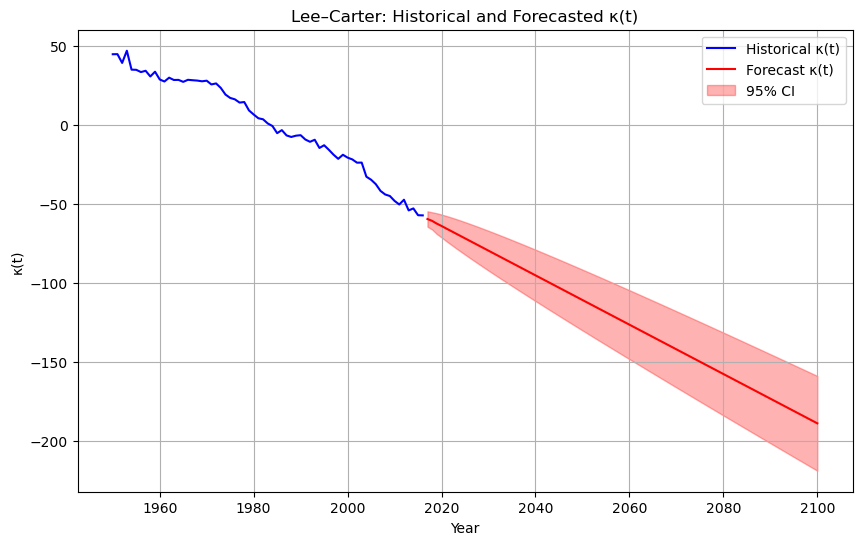

In [ ]:
def plot_kappa_forecast(lc_fit, kappa_forecast_df):

    hist_df = pd.DataFrame({
        'Year': lc_fit['years'],
        'kappa': lc_fit['kappa_t']
    }).sort_values('Year')


    fc_df = kappa_forecast_df.copy()
    fc_df.rename(columns={'kappa_forecast': 'kappa'}, inplace=True)

    plt.figure(figsize=(10, 6))
    plt.plot(hist_df['Year'], hist_df['kappa'], label='Historical \u03BA(t)', color='blue')
    plt.plot(fc_df['Year'], fc_df['kappa'], label='Forecast \u03BA(t)', color='red')

    plt.fill_between(fc_df['Year'], fc_df['lower_ci'], fc_df['upper_ci'], 
                     color='red', alpha=0.3, label='95% CI')

    plt.title('Lee–Carter: Historical and Forecasted \u03BA(t)')
    plt.xlabel('Year')
    plt.ylabel('\u03BA(t)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_kappa_forecast(lc_fit, kappa_forecast_df)

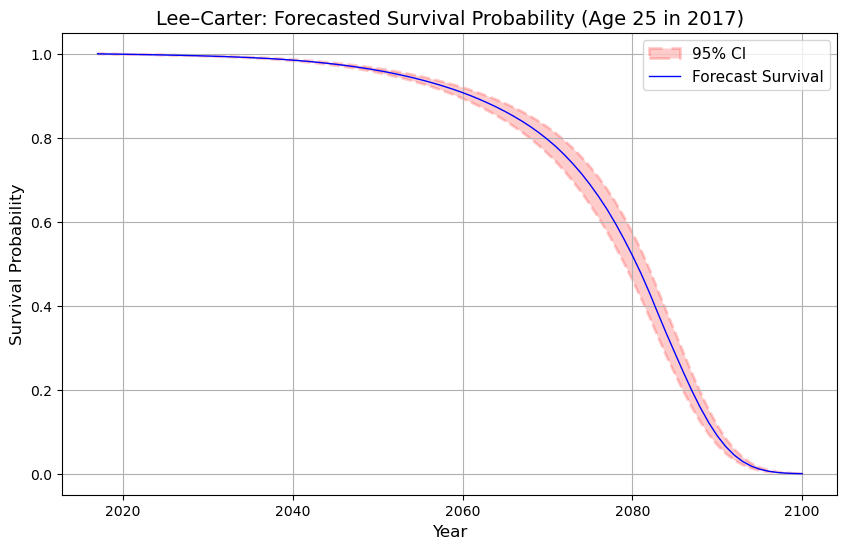

In [ ]:

# --- 1) Extract the fitted LC parameters ---
alpha_x = lc_fit['alpha_x']  # pd.Series, index = ages
beta_x_array = lc_fit['beta_x']  # np.ndarray
ages_array = lc_fit['ages']      # array of ages
beta_x = pd.Series(beta_x_array, index=ages_array)  # convert for easy lookup

# --- 2) Extract point-forecast AND lower/upper from the ARIMA of kappa_t ---
kappa_point = kappa_forecast_df['kappa_forecast'].values       # central forecast
kappa_lower = kappa_forecast_df['lower_ci'].values             # 95% lower
kappa_upper = kappa_forecast_df['upper_ci'].values             # 95% upper
forecast_years = kappa_forecast_df['Year'].values              # 2017..2100

# We'll track a person from age=25 in 2017, 26 in 2018, etc.
start_age = 25
n_forecast = len(forecast_years)
cohort_ages = np.arange(start_age, start_age + n_forecast)

# --- 3) Compute the point-forecast q_{x,t} and survival ---
q_cohort_point = []
q_cohort_lower = []
q_cohort_upper = []

for age, k_pt, k_lo, k_hi in zip(cohort_ages, kappa_point, kappa_lower, kappa_upper):
    # log(q_{x,t}) for point forecast:
    log_q_pt = alpha_x.loc[age] + beta_x.loc[age] * k_pt
    # log(q_{x,t}) for lower, upper:
    log_q_lo = alpha_x.loc[age] + beta_x.loc[age] * k_lo
    log_q_hi = alpha_x.loc[age] + beta_x.loc[age] * k_hi

    q_pt = np.exp(log_q_pt)
    q_lo = np.exp(log_q_lo)
    q_hi = np.exp(log_q_hi)

    q_cohort_point.append(q_pt)
    q_cohort_lower.append(q_lo)
    q_cohort_upper.append(q_hi)

q_cohort_point = np.array(q_cohort_point)
q_cohort_lower = np.array(q_cohort_lower)
q_cohort_upper = np.array(q_cohort_upper)

# Survival is cumulative product of (1 - q)
S_point = np.cumprod(1 - q_cohort_point)
S_lower = np.cumprod(1 - q_cohort_lower)
S_upper = np.cumprod(1 - q_cohort_upper)

# Optionally prepend S=1 at the start of the forecast (year 2017):
S_point = np.insert(S_point, 0, 1.0)
S_lower = np.insert(S_lower, 0, 1.0)
S_upper = np.insert(S_upper, 0, 1.0)

plot_years = np.insert(forecast_years, 0, forecast_years[0])

plt.figure(figsize=(10,6))

plt.fill_between(
    plot_years, 
    S_lower, 
    S_upper, 
    color='red', 
    alpha=0.2, 
    label='95% CI',
    linestyle='--',
    linewidth=2
)

plt.plot(
    plot_years, 
    S_point, 
    color='blue', 
    label='Forecast Survival', 
    linewidth=1
)


plt.xlabel('Year', fontsize=12)
plt.ylabel('Survival Probability', fontsize=12)
plt.title('Lee–Carter: Forecasted Survival Probability (Age 25 in 2017)', fontsize=14)
plt.grid(True)
plt.legend(fontsize=11)
plt.show()
